# Computer Vision Projects

## Epipolar Geometry & 8-Point Algorithm

First we are going to import the necessary libraries. Note that all the functions used in this notebook will be present in the utils.py files.

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

For this exercise the actual correspondences between the two images are provided in a text file. So we define functions to read them and pass them to points.

In [2]:
def get_coordinates(file):
    """
    Reads 2D point coordinates from a file.

    Parameters:
    file (str): Path to the file containing coordinates.

    Returns:
    np.ndarray: An array of 2D coordinates.
    """
    coordinates = []
    with open(file, "r") as coordinates_files:
        for line in coordinates_files:
            y, x = map(float, line.split())
            coordinates.append((x, y))
    coordinates = np.array(coordinates)
    return coordinates

def visualize_points(image, title, coordinates):
    """
    Displays an image with points superimposed on it.

    Parameters:
    image (np.ndarray): The image on which to display points.
    title (str): Title for the visualization.
    coordinates (list of tuples): Points to be displayed on the image.

    Returns:
    None
    """
    img = image.copy()
    plt.figure()
    for point in coordinates:
        img = cv2.circle(img, (int(point[0]), int(point[1])), radius=3, color=(255, 0, 0), thickness=-1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(title)
    plt.show()

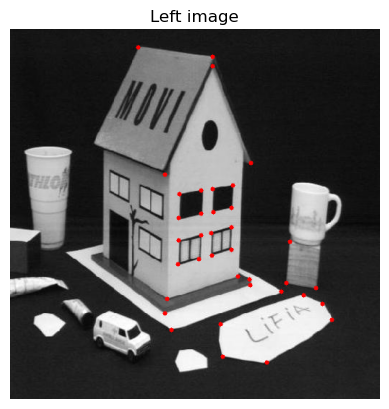

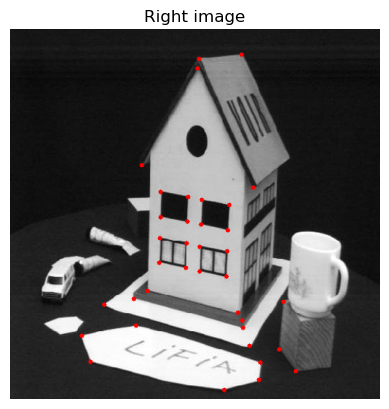

In [3]:
left = cv2.imread('images/image_left.jpg')
coordinates_left = get_coordinates('images/pt_2D_left.txt')
visualize_points(left, 'Left image', coordinates_left)

right = cv2.imread('images/image_right.jpg')
coordinates_right = get_coordinates('images/pt_2D_right.txt')
visualize_points(right, 'Right image', coordinates_right)

We define the functions that will first allow us to normalize the points to be used in the 8-point algorithm that will allow us to find our fundamental matrix that we will then use to find the epipolar lines.

In [4]:
def normalize_points(points):
    """
    Normalizes a set of points so that they are centered around the origin and their average distance from the origin is sqrt(2).

    Parameters:
    points (np.ndarray): An array of 2D points.

    Returns:
    tuple: A tuple containing the normalized points and the normalization matrix.
    """
    # Calculate the centroid and shift points to center them
    centroid = np.mean(points, axis=0)
    shifted_points = points - centroid
    
    # Scale the points so that their average distance to the origin is sqrt(2)
    dist = np.linalg.norm(shifted_points, axis=1)
    avg_dist = np.mean(dist)
    scale = np.sqrt(2) / avg_dist

    # Create the normalization matrix
    T = np.array([[scale, 0, -scale * centroid[0]],
                  [0, scale, -scale * centroid[1]],
                  [0, 0, 1]])
    
    # Apply the transformation
    points_normalized = np.dot(T, np.vstack((points.T, np.ones((1, points.shape[0])))))
    return points_normalized.T, T

def normalized_eight_points(left, right):
    """
    Computes the Fundamental Matrix using the normalized eight-point algorithm.

    Parameters:
    left (np.ndarray): Array of 2D points from the first image.
    right (np.ndarray): Array of 2D points from the second image.

    Returns:
    np.ndarray: The computed Fundamental Matrix.
    """
    # Normalize points
    norm_left, F_left = normalize_points(left)
    norm_right, F_right = normalize_points(right)

    # Construct matrix A for the linear equation system
    A = []
    for i in range(norm_left.shape[0]):
        x0, y0 = norm_left[i, :2]
        x1, y1 = norm_right[i, :2]
        A.append([x0 * x1, y0 * x1, x1, y1 * x0, y1 * y0, y1, x0, y0, 1])
    A = np.array(A)
    
    # Perform Singular Value Decomposition (SVD) on A
    U, S, Vt = np.linalg.svd(A)
    Fi = Vt[-1].reshape(3, 3)

    # Enforce the rank-2 constraint
    Uf, Sf, Vtf = np.linalg.svd(Fi)
    Sf[-1] = 0  # Force the determinant to be 0
    F_prime = Uf @ np.diag(Sf) @ Vtf

    # Denormalize the Fundamental Matrix
    F = F_right.T @ F_prime @ F_left
    return F

In [5]:
F = normalized_eight_points(coordinates_left, coordinates_right)

Now with the fundamental matrix found. Let's find the epipolar lines for each of the two images

In [6]:
def drawlines(img, lines, pts1):
    """
    Draws epipolar lines on the image.

    Parameters:
    img (np.ndarray): The image on which to draw the lines.
    lines (np.ndarray): Array of epipolar lines.
    pts1 (list of tuples): Corresponding points in the image.

    Returns:
    np.ndarray: Image with epipolar lines drawn.
    """
    _, c = img.shape[:2]
    for r, pt1 in zip(lines, pts1):
        pt1 = (int(pt1[0]), int(pt1[1]))
        color = tuple(np.random.randint(0, 255, 3).tolist())
        # Calculate start and end points of the epipolar line
        x0, y0 = map(int, [0, -r[2]/r[1]])
        x1, y1 = map(int, [c, -(r[2] + r[0]*c)/r[1]])
        # Draw the epipolar line on the image
        img = cv2.line(img, (x0, y0), (x1, y1), color, 1)
        # Draw the corresponding points on the image
        img = cv2.circle(img, pt1, 5, color, -1)
    return img

<Figure size 640x480 with 0 Axes>

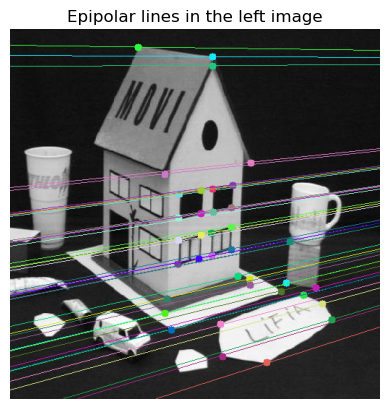

In [7]:
lines1 = cv2.computeCorrespondEpilines(np.expand_dims(coordinates_right, axis=1), 2, F)
lines1 = lines1.reshape(-1,3)

right_with_epilines = drawlines(left, lines1, coordinates_left)

plt.figure()
plt.show()
plt.imshow(cv2.cvtColor(right_with_epilines, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Epipolar lines in the left image')
plt.show()

<Figure size 640x480 with 0 Axes>

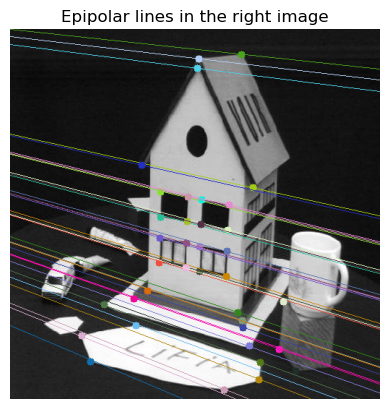

In [8]:
lines2 = cv2.computeCorrespondEpilines(np.expand_dims(coordinates_left, axis=1), 1, F)
lines2 = lines2.reshape(-1,3)

left_with_epilines = drawlines(right, lines2, coordinates_right)

plt.figure()
plt.show()
plt.imshow(cv2.cvtColor(left_with_epilines, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Epipolar lines in the right image')
plt.show()

Also, as part of the activity we are asked to calculate the estimation error. In this case, we are asked to calculate it as the average of the Euclidean distance between the points and the epipolar lines.

In [9]:
def calculate_estimation_error(lines, points):
    """
    Calculates the average distance of points from their corresponding epipolar lines.

    Parameters:
    lines (np.ndarray): Epipolar lines.
    points (np.ndarray): Corresponding points.

    Returns:
    float: The average distance (error).
    """
    distance = 0
    for point, line in zip(points, lines):
        a, b, c = line
        x, y = point
        # Calculate the distance of a point from the line
        distance += abs(a*x + b*y + c) / np.sqrt(a**2 + b**2)
    return distance / lines.shape[0]

In [10]:
error_left = calculate_estimation_error(lines1, coordinates_left)
print('For the left image the estimation error is: {}'.format(error_left))

error_right = calculate_estimation_error(lines2, coordinates_right)
print('For the right image the estimation error is: {}'.format(error_right))

For the left image the estimation error is: 0.8286681346568345
For the right image the estimation error is: 0.8905729362029415


## Same process using SIFT detector

For the second part of this exercise, we are asked to use the detectors and the SIFT descriptors to find the correspondences to find the epipolar lines instead of using the correspondences given above in the file. Although we only use SIFT, we are going to reuse the code used in another project where we also have the possibility to use ORB.

The first thing we are going to do is to find the keypoints in both images and keep the best 200.

In [11]:
def get_the_N_information(image, detector, n=200):
    """
    Extracts the top N keypoints and their descriptors from an image using SIFT or ORB detectors.

    Parameters:
    image (np.ndarray): The input image.
    detector (str): The type of feature detector ('SIFT' or other for 'ORB').
    n (int): The number of top keypoints to extract.

    Returns:
    tuple: A tuple containing sorted keypoints and their descriptors.
    """
    # Initialize the feature detector based on the input parameter
    if detector == 'SIFT':
        sift = cv2.SIFT_create()
        keypoints, descriptors = sift.detectAndCompute(image, None)
    else:
        orb = cv2.ORB_create()
        keypoints, descriptors = orb.detectAndCompute(image, None)

    print(f'The number of keypoints with {detector} is {len(keypoints)}')

    # Convert keypoints to a NumPy array for response values
    responses = np.array([kp.response for kp in keypoints])

    # Sort the indices of keypoints based on the response
    indices = np.argsort(responses)[::-1]

    # Reorder keypoints and descriptors using the sorted indices
    keypoints_sorted = [keypoints[i] for i in indices][:n]
    descriptors_sorted = descriptors[indices][:n]

    # Draw keypoints on the image and display it
    img_kp = cv2.drawKeypoints(image, keypoints_sorted, None, color=(255,0,0))
    plt.imshow(img_kp)
    plt.axis('off')
    plt.show()
    return keypoints_sorted, descriptors_sorted


The number of keypoints with SIFT is 676


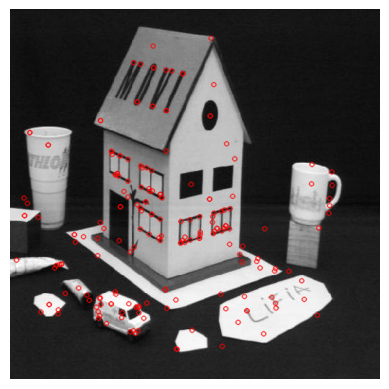

The number of keypoints with SIFT is 514


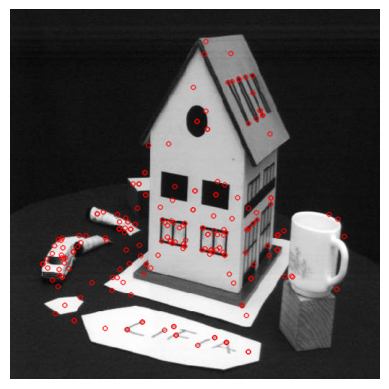

In [12]:
left = cv2.imread('images/image_left.jpg')
keypoints_left, descriptors_left = get_the_N_information(left, 'SIFT')

right = cv2.imread('images/image_right.jpg')
keypoints_right, descriptors_right = get_the_N_information(right, 'SIFT')

To find the correspondences between both images, let's first create the distance matrix and then apply 1NN/2NNN with cross validation to make sure that the correspondences are correct.

In [13]:
def create_distance_matrix(descriptor_1, descriptor_2, descriptor):
    """
    Creates a distance matrix between two sets of descriptors.

    Parameters:
    descriptor_1 (np.ndarray): The first set of descriptors.
    descriptor_2 (np.ndarray): The second set of descriptors.
    descriptor (str): The type of descriptor ('SIFT' or other for 'ORB').

    Returns:
    np.ndarray: The distance matrix.
    """
    width = descriptor_1.shape[0]
    distance = np.zeros((width, width))

    # Compute the distance matrix based on the type of descriptor
    if descriptor == 'SIFT':
        for i in range(width):
            one_row_matrix = np.reshape(descriptor_1[i], (1, -1)).repeat(width, 0)
            dist = np.sqrt(np.sum((one_row_matrix - descriptor_2) ** 2, axis=1))
            distance[i] = dist
    else:
        for i in range(width):
            for j in range(width):
                # Calculate Hamming distance between two vectors
                distance[i, j] = np.sum(descriptor_1[i] != descriptor_2[j])
    return distance

def NN_and_cross_validation(distance_matrix):
    """
    Finds correspondences between keypoints using NN and cross-validation.

    Parameters:
    distance_matrix (np.ndarray): The distance matrix between two sets of descriptors.

    Returns:
    list: A list of cv2.DMatch objects representing the correspondences.
    """
    size = distance_matrix.shape[0]
    threshold = .75
    correspondences = []

    for i in range(size):
        line = distance_matrix[i]
        # Obtain the nearest and second nearest neighbor
        first_and_second = np.sort(line)[:2]
        # Apply 1NN/2NN threshold
        if (first_and_second[0] / first_and_second[1]) < threshold:
            ind = np.argmin(line)
            # Apply cross-validation check
            if np.argmin(distance_matrix[:, ind]) == i:
                match = cv2.DMatch(i, ind, first_and_second[0])
                correspondences.append(match)
    return correspondences

def create_correspondences(descriptor_1, descriptor_2, descriptor):
    """
    Creates correspondences between two sets of descriptors.

    Parameters:
    descriptor_1 (np.ndarray): The first set of descriptors.
    descriptor_2 (np.ndarray): The second set of descriptors.
    descriptor (str): The type of descriptor ('SIFT' or other for 'ORB').

    Returns:
    list: A list of cv2.DMatch objects representing the correspondences.
    """
    dis = create_distance_matrix(descriptor_1, descriptor_2, descriptor)
    corr = NN_and_cross_validation(dis)
    return corr

In [14]:
matches = create_correspondences(descriptors_left, descriptors_right, 'SIFT')
print(('The number of correspondences after the test is {}').format((len(matches))))

The number of correspondences after the test is 15


We will now proceed to visualize these correspondences in both images. We can see that in spite of the tests the correspondences are not as exact as the ones provided in the file. For this we use this function that returns the coordinates of each of the points.

In [15]:
def get_points(matches, kp1, kp2):
    """
    Extracts point coordinates from keypoint matches.

    Parameters:
    matches (list): A list of cv2.DMatch objects.
    kp1 (list): The keypoints from the first image.
    kp2 (list): The keypoints from the second image.

    Returns:
    tuple: Two arrays containing the coordinates of the matched keypoints.
    """
    indexes1 = np.array([match.queryIdx for match in matches])
    indexes2 = np.array([match.trainIdx for match in matches])

    points1 = np.array([kp1[ind].pt for ind in indexes1])
    points2 = np.array([kp2[ind].pt for ind in indexes2])
    return points1, points2

left_points, right_points = get_points(matches, keypoints_left, keypoints_right)

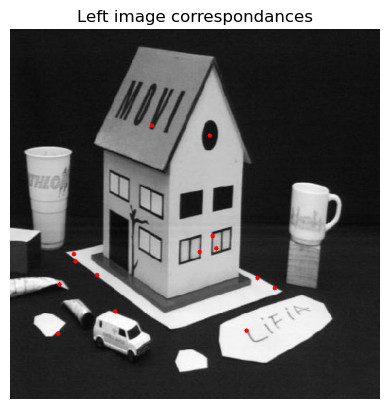

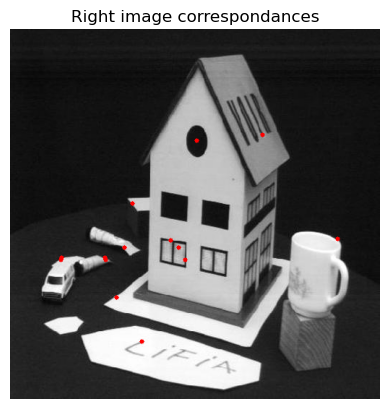

In [16]:
left_points, right_points = get_points(matches, keypoints_left, keypoints_right)
visualize_points(left, 'Left image correspondances', left_points)
visualize_points(right, 'Right image correspondances', right_points)

Now let's run the 8-point algorithm with these correspondences to see how it affects the fact that they are not as accurate as those provided in the file.

In [17]:
F = normalized_eight_points(left_points, right_points)

<Figure size 640x480 with 0 Axes>

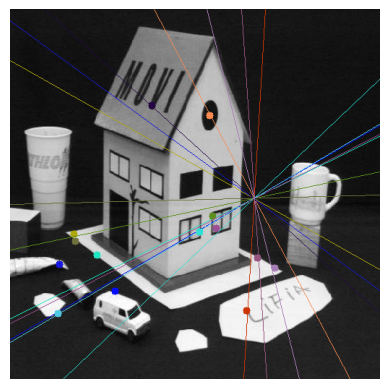

In [18]:
lines1 = cv2.computeCorrespondEpilines(np.expand_dims(right_points, axis=1), 2, F)
lines1 = lines1.reshape(-1,3)

right_with_epilines = drawlines(left, lines1, left_points)

plt.figure()
plt.show()
plt.imshow(cv2.cvtColor(right_with_epilines, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

<Figure size 640x480 with 0 Axes>

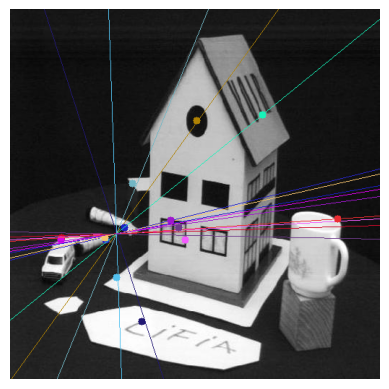

In [19]:
lines2 = cv2.computeCorrespondEpilines(np.expand_dims(left_points, axis=1), 1, F)
lines2 = lines2.reshape(-1,3)

left_with_epilines = drawlines(right, lines2, right_points)

plt.figure()
plt.show()
plt.imshow(cv2.cvtColor(left_with_epilines, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

We can see from the results that of the 15 matches found after the tests, not all are real. Visually we can see that there are less than 8 real correspondences so that with SIFT we could not find the epipolar lines correctly.